In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/dataset/MVSA-multiple.zip'
extract_path = '/content/dataset'

# Create the extraction directory
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction
os.listdir(extract_path)

['MVSA']

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Input, LSTM, Bidirectional, Embedding, GRU, Multiply, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:

# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# Load data
label_results_path = os.path.join(extract_path, 'MVSA/labelResultAll.txt')
data_folder_path = os.path.join(extract_path, 'MVSA/data')
label_results = pd.read_csv(label_results_path, delimiter='\t', header=None, names=['ID', 'annotation1', 'annotation2', 'annotation3'])

# Split annotations and get majority sentiment
def safe_split(annotation):
    parts = annotation.split(',')
    return parts if len(parts) == 2 else ['unknown', 'unknown']

for i in range(3):
    label_results[[f'text_sentiment_{i+1}', f'image_sentiment_{i+1}']] = label_results[f'annotation{i+1}'].apply(safe_split).apply(pd.Series)
label_results.drop(columns=[f'annotation{i+1}' for i in range(3)], inplace=True)

from collections import Counter
def get_majority_sentiment(row):
    text_sentiments = row[[f'text_sentiment_{i+1}' for i in range(3)]]
    image_sentiments = row[[f'image_sentiment_{i+1}' for i in range(3)]]
    text_sentiment = Counter(text_sentiments).most_common(1)[0][0] if Counter(text_sentiments).most_common(1)[0][1] > 1 else 'unknown'
    image_sentiment = Counter(image_sentiments).most_common(1)[0][0] if Counter(image_sentiments).most_common(1)[0][1] > 1 else 'unknown'
    return pd.Series([text_sentiment, image_sentiment], index=['text_sentiment', 'image_sentiment'])

label_results[['text_sentiment', 'image_sentiment']] = label_results.apply(get_majority_sentiment, axis=1)
label_results = label_results[(label_results['text_sentiment'] != 'unknown') & (label_results['image_sentiment'] != 'unknown')]

# Load the image-text data
files = os.listdir(data_folder_path)
image_files = [f for f in files if f.endswith('.jpg')]
text_files = [f for f in files if f.endswith('.txt')]

# Function to read text file with different encodings
def read_text_file(file_path):
    encodings = ['utf-8', 'latin-1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except UnicodeDecodeError:
            continue
    return None

data = {'ID': [], 'image_path': [], 'text': []}
for image_file in image_files:
    file_id = os.path.splitext(image_file)[0]
    text_file = file_id + '.txt'
    if text_file in text_files:
        text_content = read_text_file(os.path.join(data_folder_path, text_file))
        if text_content:
            data['ID'].append(file_id)
            data['image_path'].append(os.path.join(data_folder_path, image_file))
            data['text'].append(text_content)

df = pd.DataFrame(data)
df['ID'] = df['ID'].astype(str)
label_results['ID'] = label_results['ID'].astype(str)
df = pd.merge(df, label_results[['ID', 'text_sentiment', 'image_sentiment']], on='ID')

# Filter to keep only rows where text sentiment and image sentiment are the same
df = df[df['text_sentiment'] == df['image_sentiment']]




In [ ]:
# Convert labels to numerical values
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['text_sentiment'] = df['text_sentiment'].map(label_mapping)
df['image_sentiment'] = df['image_sentiment'].map(label_mapping)

# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['processed_text'].values)
sequences = tokenizer.texts_to_sequences(df['processed_text'].values)

# Define maximum length based on 95% coverage
df['text_length'] = df['processed_text'].apply(lambda x: len(x.split()))
max_length_coverage = df['text_length'].quantile(0.95)
max_sequence_length = int(max_length_coverage)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Encode the sentiment labels for text data
y_text = tf.keras.utils.to_categorical(df['text_sentiment'], num_classes=3)

In [ ]:
# Image preprocessing with advanced augmentations
img_height, img_width = 224, 224
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

image_data = np.array([load_and_preprocess_image(img_path)[0] for img_path in df['image_path']])

# Train-test split
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(padded_sequences, y_text, test_size=0.2, random_state=42, stratify=y_text)
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(image_data, y_text, test_size=0.2, random_state=42, stratify=y_text)

# Adjust class weights
class_weights_dict = {
    0: 1.0 * 4.0,  # Increase weight for Negative class, moderate increase
    1: 0.98 * 1.5, # Moderate increase for Neutral class
    2: 1.0         # Keep Positive class weight as is
}

In [ ]:
def build_fusion_model(hp):
    # Text Model
    text_input = Input(shape=(X_train_text.shape[1],))
    x_text = Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=32))(text_input)
    for i in range(hp.Int('lstm_layers', 1, 3)):
        x_text = Bidirectional(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                                    return_sequences=(i < hp.Int('lstm_layers', 1, 3) - 1),
                                    kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg_text', values=[1e-4, 1e-3]))))(x_text)
        x_text = BatchNormalization()(x_text)
        x_text = Dropout(rate=hp.Float('dropout_rate_text', min_value=0.3, max_value=0.5, step=0.1))(x_text)

    # CNN Model (Image)
    base_model = DenseNet121(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
    x_img = base_model.output
    for i in range(hp.Int('cnn_layers', 1, 3)):
        x_img = Conv2D(hp.Int('filters', 32, 128, step=32), (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg_img', values=[1e-4, 1e-3])))(x_img)
        if x_img.shape[1] > 2 and x_img.shape[2] > 2:
            x_img = MaxPooling2D((2, 2))(x_img)
        x_img = BatchNormalization()(x_img)
        x_img = Dropout(hp.Float('dropout_rate_img', min_value=0.3, max_value=0.5, step=0.1))(x_img)

    x_img = GlobalAveragePooling2D()(x_img)

    # Fusion  Mechanism
    combined_input = concatenate([x_text, x_img])

    # Attention Mechanism
    attention = Dense(128, activation='tanh')(combined_input)
    attention = Dense(1, activation='sigmoid')(attention)
    attention = Multiply()([combined_input, attention])

    # Dense Layers
    fusion_output = Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg_fusion', values=[1e-4, 1e-3])))(attention)
    fusion_output = Dropout(hp.Float('dropout_rate_fusion', min_value=0.3, max_value=0.5, step=0.1))(fusion_output)
    fusion_output = BatchNormalization()(fusion_output)
    final_output = Dense(3, activation='softmax')(fusion_output)

    model = Model(inputs=[text_input, base_model.input], outputs=final_output)
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

    model.summary()


In [ ]:


tuner = RandomSearch(
    build_fusion_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/sentiment_analysis_model_fusion1/',
    project_name='fusion_model_tuning'
)

# Run the hyperparameter search
tuner.search([X_train_text, X_train_img], y_train_text, epochs=50, validation_split=0.2,
             class_weight=class_weights_dict,  # Apply class weights during tuning
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Get the best hyperparameters and train the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
fusion_model = tuner.hypermodel.build(best_hps)
history = fusion_model.fit([X_train_text, X_train_img], y_train_text, epochs=50, batch_size=32,
                           validation_split=0.2, class_weight=class_weights_dict,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Save the best fusion model
fusion_model_save_path = '/content/drive/MyDrive/sentiment_analysis_model_fusion1/best_fusion_model.keras'
fusion_model.save(fusion_model_save_path)


Reloading Tuner from /content/drive/MyDrive/sentiment_analysis_model_fusion1/fusion_model_tuning/tuner0.json
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 131s 214ms/step - accuracy: 0.3381 - loss: 2.5889 - val_accuracy: 0.4430 - val_loss: 1.7240
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.4725 - loss: 2.1031 - val_accuracy: 0.4851 - val_loss: 1.6165
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.5315 - loss: 1.9292 - val_accuracy: 0.5491 - val_loss: 1.4803
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.5844 - loss: 1.7432 - val_accuracy: 0.6042 - val_loss: 1.4116
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.6539 - loss: 1.5581 - val_accuracy: 0.5312 - val_loss: 1.5524
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.7125 - loss: 1.3856 - val_accuracy: 0.6314 - val_loss: 1.4907
Epoch 7/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/ste

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
print(f"Best embedding dimension: {best_hps.get('embedding_dim')}")
print(f"Number of LSTM layers: {best_hps.get('lstm_layers')}")
for i in range(best_hps.get('lstm_layers')):
    print(f"LSTM units in layer {i+1}: {best_hps.get(f'lstm_units_{i}')}")
print(f"Dropout rate for text: {best_hps.get('dropout_rate_text')}")
print(f"Number of CNN layers: {best_hps.get('cnn_layers')}")
print(f"Filters in CNN layers: {best_hps.get('filters')}")
print(f"Dropout rate for image: {best_hps.get('dropout_rate_img')}")
print(f"Dense layer units: {best_hps.get('dense_units')}")
print(f"Dropout rate for fusion: {best_hps.get('dropout_rate_fusion')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")


Best embedding dimension: 64
Number of LSTM layers: 2
LSTM units in layer 1: 96
LSTM units in layer 2: 64
Dropout rate for text: 0.3
Number of CNN layers: 1
Filters in CNN layers: 32
Dropout rate for image: 0.5
Dense layer units: 128
Dropout rate for fusion: 0.4
Learning rate: 0.0001


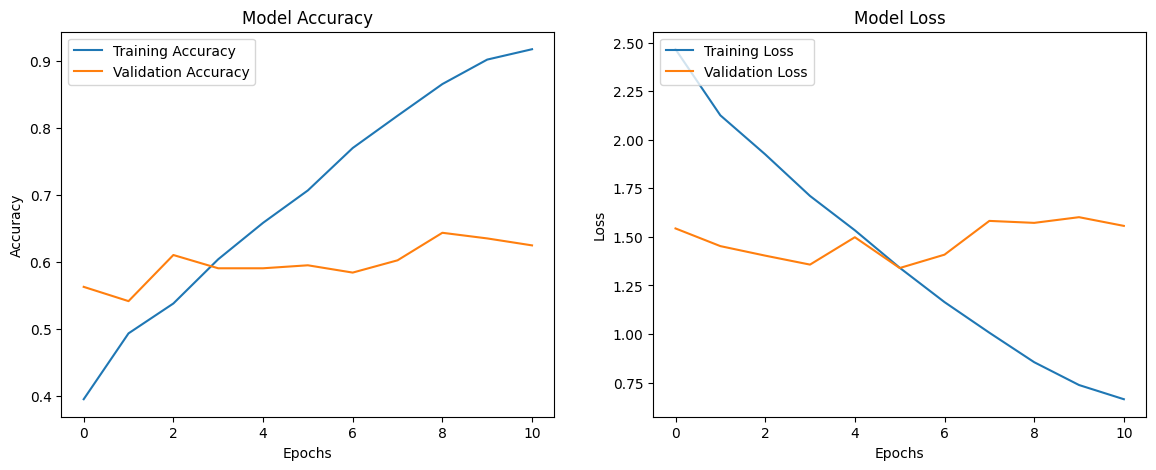

In [ ]:
import matplotlib.pyplot as plt

def plot_training_validation_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Call the function to plot the metrics
plot_training_validation_metrics(history)


In [ ]:

# Evaluate the model
val_loss, val_accuracy = fusion_model.evaluate([X_val_text, X_val_img], y_val_text)


# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
y_pred = fusion_model.predict([X_val_text, X_val_img])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_text, axis=1)
print("Classification Report:\n", classification_report(y_true, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6509 - loss: 1.4418
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.12      0.18       121
           1       0.52      0.58      0.55       882
           2       0.73      0.73      0.73      1517

    accuracy                           0.65      2520
   macro avg       0.56      0.47      0.49      2520
weighted avg       0.65      0.65      0.64      2520

Confusion Matrix:
 [[  14   71   36]
 [   7  510  365]
 [  11  397 1109]]


In [ ]:
import tensorflow as tf

# Load the Text (RNN/LSTM) model
text_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis_model17/best_text_model1.keras')

# Load the DenseNet (CNN) model
densenet_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis_model54/best_densenet_model.keras')




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats
import numpy as np

# Assuming y_val_text and y_val_img are the true labels
# y_val_text should be used as the ground truth for all models as it represents the correct labels.

# Generate predictions
text_predictions = text_model.predict(X_val_text)
image_predictions = densenet_model.predict(X_val_img)
fusion_predictions = fusion_model.predict([X_val_text, X_val_img])

# Convert predictions from one-hot encoding to class labels
text_pred_classes = np.argmax(text_predictions, axis=1)
image_pred_classes = np.argmax(image_predictions, axis=1)
fusion_pred_classes = np.argmax(fusion_predictions, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true = np.argmax(y_val_text, axis=1)

# Calculate performance metrics for each model
metrics = {
    'text': {
        'accuracy': accuracy_score(y_true, text_pred_classes),
        'precision': precision_score(y_true, text_pred_classes, average='macro'),
        'recall': recall_score(y_true, text_pred_classes, average='macro'),
        'f1_score': f1_score(y_true, text_pred_classes, average='macro')
    },
    'image': {
        'accuracy': accuracy_score(y_true, image_pred_classes),
        'precision': precision_score(y_true, image_pred_classes, average='macro'),
        'recall': recall_score(y_true, image_pred_classes, average='macro'),
        'f1_score': f1_score(y_true, image_pred_classes, average='macro')
    },
    'fusion': {
        'accuracy': accuracy_score(y_true, fusion_pred_classes),
        'precision': precision_score(y_true, fusion_pred_classes, average='macro'),
        'recall': recall_score(y_true, fusion_pred_classes, average='macro'),
        'f1_score': f1_score(y_true, fusion_pred_classes, average='macro')
    }
}

print("Performance Metrics:")
for model, metric in metrics.items():
    print(f"\n{model.capitalize()} Model Metrics:")
    for metric_name, value in metric.items():
        print(f"{metric_name.capitalize()}: {value:.4f}")

# Since the t-tests require paired observations, we can simulate this by considering each prediction's correctness
# as a paired observation (i.e., whether the prediction is correct or not).

# Compute binary correct/incorrect predictions
text_correct = (text_pred_classes == y_true).astype(int)
image_correct = (image_pred_classes == y_true).astype(int)
fusion_correct = (fusion_pred_classes == y_true).astype(int)

# Conduct paired t-tests on correct/incorrect predictions
t_test_results = {
    'text_vs_fusion': stats.ttest_rel(text_correct, fusion_correct),
    'image_vs_fusion': stats.ttest_rel(image_correct, fusion_correct),
}

print("\nPaired t-test Results:")
for comparison, t_stat in t_test_results.items():
    print(f"{comparison.replace('_', ' ').capitalize()}:")
    print(f"t-statistic = {t_stat.statistic:.4f}, p-value = {t_stat.pvalue:.4f}")

# Interpretation: If the p-value < 0.05, reject the null hypothesis and conclude that the fusion model
# significantly outperforms the individual models.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Performance Metrics:

Text Model Metrics:
Accuracy: 0.6242
Precision: 0.5027
Recall: 0.4829
F1_score: 0.4899

Image Model Metrics:
Accuracy: 0.5750
Precision: 0.4223
Recall: 0.4048
F1_score: 0.4090

Fusion Model Metrics:
Accuracy: 0.6480
Precision: 0.5645
Recall: 0.4750
F1_score: 0.4880

Paired t-test Results:
Text vs fusion:
t-statistic = -2.2044, p-value = 0.0276
Image vs fusion:
t-statistic = -6.1507, p-value = 0.0000
